# Generating Dataset

In [5]:
import pandas as pd
import random
import datetime as dt
import datetime
import json
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import dgl
from statistics import mean
from operator import itemgetter

In [6]:
# Constants
# Control Parameters

CONTROL_PARAMS = {
'DEFAULT_AGE_LB' : 20,
'DEFAULT_AGE_UB' : 40,

'NUM_ADULTS_PROBABILITIES' : [0, 0.65, 1],
'NUM_CHILDREN_PROBABILITIES' : [0.2, 0.45, 0.9, 1],
'NUM_PARENTS_PROBABILITIES' : [0.5, 0.65, 1],

'ADULT_AGE_RANGE' : (30, 50),

'BMI_LB' : 15,
'BMI_UB' : 28,
'BMI_RANGE' : (15, 28),

'CHILDREN_AGE_DIFF_LB' : 25,
'CHILDREN_AGE_DIFF_UB' : 28,

'PARENT_AGE_DIFF_LB' : 30,
'PARENT_AGE_DIFF_UB' : 35,

'FAMILY_PER_APARTMENT' : 20,

'APARTMENTS' : 3,
'HOMES' : 25,

'RETIREMENT_AGE' : 65,
'OFFICE_AGE' : 25,
'UNI_AGE' : 18,
'COLLEGE_AGE' : 16,
'SECONDARY_AGE' : 11,
'PRIMARY_AGE' : 5,

'EMPLOYMENT_RATE' : 0.6,
'UNI_RATE' : 0.7,
'COLLEGE_RATE' : 0.75,
'SECONDARY_RATE' : 0.9,
'PRIMARY_RATE' : 0.95,
'PRE_RATE' : 0.99,

'OFFICE_CAPACITY' : 75,
'SHOP_CAPACITY' : 30,

'APARTMENT_CONTACTS_SCALE' : 1,
'OFFICE_CONTACTS_SCALE' : 1.5,
'SCHOOL_CONTACTS_SCALE' : 2,
'SHOP_CONTACTS_SCALE' : 2,
'FAMILY_CONTACTS_SCALE' : 2
}

# Metadata

In [7]:
def pick(probabilities):
    val = random.random()
    for i, probability in enumerate(probabilities):
        if val <= probability:
            return i

In [8]:
class Person:
    count = 0
    people = []

    def __init__(self, family, age=None, bmi=None, apartment=-1, home=-1):
        self.id = Person.count
        self.age = random.randint(CONTROL_PARAMS['DEFAULT_AGE_LB'], CONTROL_PARAMS['DEFAULT_AGE_UB']) if age == None else random.randint(age[0], age[1])
        self.bmi = random.randint(CONTROL_PARAMS['BMI_LB'], CONTROL_PARAMS['BMI_UB']) if bmi == None else random.randint(bmi[0], bmi[1])
        self.apartment = apartment
        self.home = home
        self.family = family
        self.office = -1
        self.school = -1

        Person.count = Person.count + 1

    def __repr__(self):
        return str({
            'id': self.id,
            'age': self.age,
            'bmi': self.bmi,
            'apartment': self.apartment,
            'home': self.home,
            'family': self.family,
            'office': self.office,
            'school': self.school
        })

In [9]:
class Family:
    # assuming a city population
    # imagine families to be based around 1 or 2 adults of age [30, 60]
    # having a bmi between [15, 28]
    # having chance c of having children 1, 2 or 3 children of age [1, m - [25-30]]
    # where m in the age of the younger adult
    # and having chance p of living with 0, 1 or 2 of their parents
    # whose age would be in range [M + [20-25], 85]
    count = 0

    a = CONTROL_PARAMS["NUM_ADULTS_PROBABILITIES"]
    c = CONTROL_PARAMS["NUM_CHILDREN_PROBABILITIES"]
    p = CONTROL_PARAMS["NUM_PARENTS_PROBABILITIES"]
    def __init__(self, n=None, apartment=-1, home=-1):
        self.members = []
        self.id = Family.count
        Family.count = Family.count + 1

        if n is not None:
            for _ in range(n):
                person = Person(family=self.id, apartment=apartment, home=home)
                Person.people.append(person)
                self.members.append(person.id)
    
        adults = pick(Family.a)
        children = pick(Family.c)
        parents = pick(Family.p)

        m = 100
        M = -1

        for _ in range(adults):
            person = Person(age=CONTROL_PARAMS["ADULT_AGE_RANGE"], bmi=CONTROL_PARAMS["BMI_RANGE"], family=self.id, apartment=apartment, home=home)
            Person.people.append(person)
            m = min(m, person.age)
            M = max(M, person.age)
            self.members.append(person.id)

        for _ in range(children):
            person = Person(age=(1, m - random.randint(CONTROL_PARAMS['CHILDREN_AGE_DIFF_LB'], CONTROL_PARAMS['CHILDREN_AGE_DIFF_UB'])), bmi=CONTROL_PARAMS['BMI_RANGE'], apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

        for _ in range(parents):
            person = Person(age=(M + CONTROL_PARAMS['PARENT_AGE_DIFF_LB'], M + CONTROL_PARAMS['PARENT_AGE_DIFF_UB']), bmi=CONTROL_PARAMS['BMI_RANGE'], apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.members)


In [10]:
class Home:
    count = 0

    def __init__(self):
        self.id = Home.count
        self.family = Family(home=self.id)
        Home.count = Home.count + 1

    def __repr__(self):
        return str(self.id) + ":" + str(self.family)


In [11]:
class Apartment:
    size = CONTROL_PARAMS["FAMILY_PER_APARTMENT"]
    count = 0
    
    def __init__(self):
        self.families = [Family(apartment=Apartment.count) for _ in range(Apartment.size)]
        self.people = set()
        for family in self.families:
            self.people.update(family.members)
        Apartment.count = Apartment.count + 1

    def __repr__(self):
        return str(self.families)

In [12]:
class Office:
    count = 0

    def __init__(self):
        self.id = Office.count
        Office.count = Office.count + 1
        self.employees = set()

    def hire(self, id):
        Person.people[id].office = self.id
        self.employees.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.employees)


In [13]:
class School:
    count = 0

    def __init__(self):
        self.id = School.count
        School.count = School.count + 1
        self.students = set()

    def admit(self, id):
        Person.people[id].school = self.id
        self.students.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.students)

In [14]:
class Society:
    
    def __init__(
        self,
        apartments=CONTROL_PARAMS["APARTMENTS"],
        homes=CONTROL_PARAMS["HOMES"]
    ):
        self.n_apartments = apartments
        self.apartments = [Apartment() for _ in range(apartments)]

        self.n_homes = homes
        self.homes = [Home() for _ in range(homes)]

        self.n_offices = Person.count // CONTROL_PARAMS['OFFICE_CAPACITY'] + 1
        self.offices = [Office() for _ in range(self.n_offices)]
        
        self.pre = School()
        self.primary = School()
        self.secondary = School()
        self.college = School()
        self.uni = School()
        
        for person in Person.people:
            if person.age > CONTROL_PARAMS['RETIREMENT_AGE']:
                continue
            if person.age >= CONTROL_PARAMS['OFFICE_AGE']:
                if random.random() <= CONTROL_PARAMS['EMPLOYMENT_RATE']:
                    self.offices[random.randint(1, self.n_offices) - 1].hire(person.id)
            elif person.age >= CONTROL_PARAMS['UNI_AGE']:
                if random.random() <= CONTROL_PARAMS['UNI_RATE']:
                    self.uni.admit(person.id)
            elif person.age >= CONTROL_PARAMS['COLLEGE_AGE']:
                if random.random() <= CONTROL_PARAMS['COLLEGE_RATE']:
                    self.college.admit(person.id)
            elif person.age >= CONTROL_PARAMS['SECONDARY_AGE']:
                if random.random() <= CONTROL_PARAMS['SECONDARY_RATE']:
                    self.secondary.admit(person.id)
            elif person.age >= CONTROL_PARAMS['PRIMARY_AGE']:
                if random.random() <= CONTROL_PARAMS['PRIMARY_RATE']:
                    self.primary.admit(person.id)
            else:
                if random.random() <= CONTROL_PARAMS['PRE_RATE']:
                    self.pre.admit(person.id)

In [15]:
society = Society()

In [16]:
id = [person.id for person in Person.people]
age = [person.age for person in Person.people]
bmi = [person.bmi for person in Person.people]
apartment = [person.apartment for person in Person.people]
home = [person.home for person in Person.people]
family = [person.family for person in Person.people]
office = [person.office for person in Person.people]
school = [person.school for person in Person.people]

In [17]:
print(f"There are {Person.count} people in the society")

There are 321 people in the society


In [18]:
def hist(data):
    fig, axis = plt.subplots(figsize =(10, 5))
    axis.hist(data)
    plt.show()

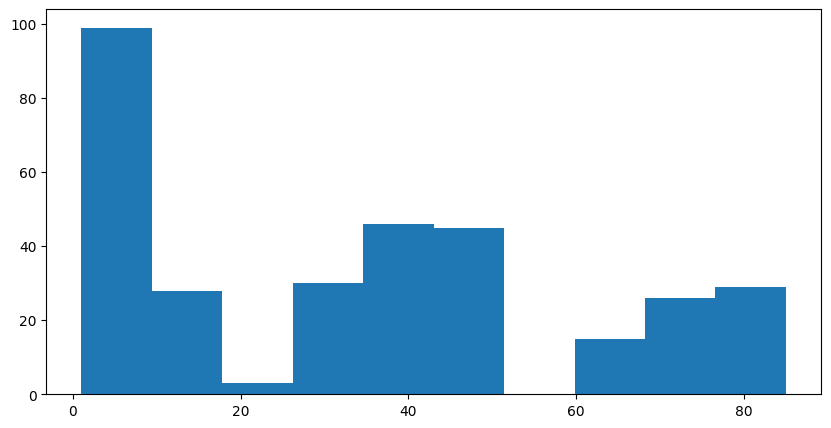

In [19]:
hist(age)

In [20]:
print(mean(age))

33.90965732087228


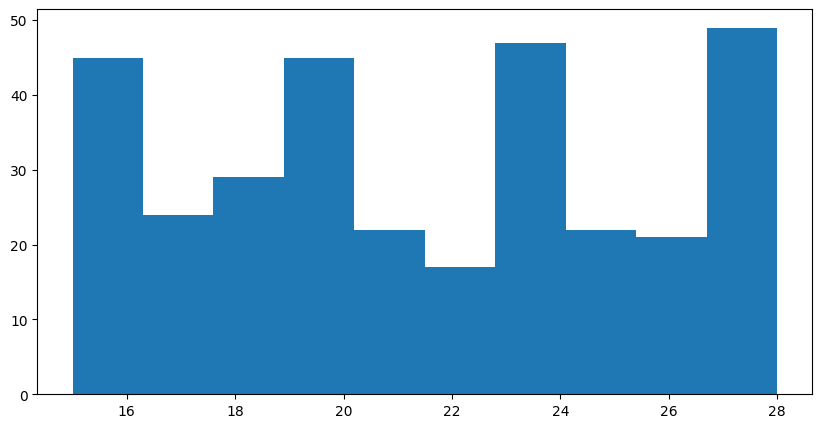

In [21]:
hist(bmi)

In [22]:
print(mean(bmi))

21.46417445482866


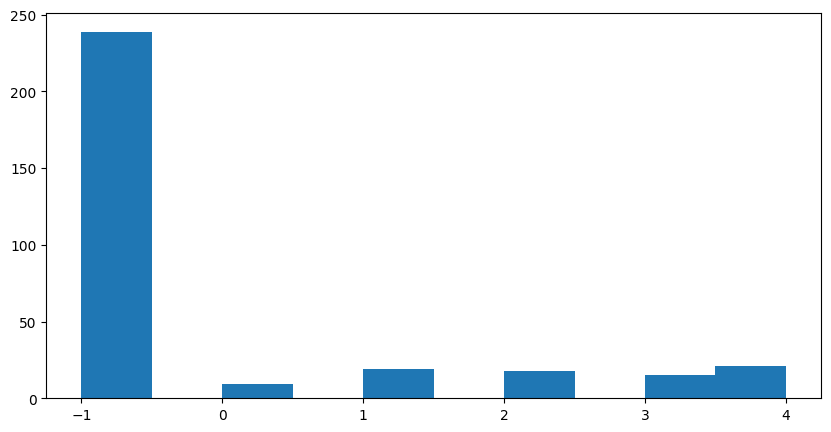

In [23]:
hist(office)

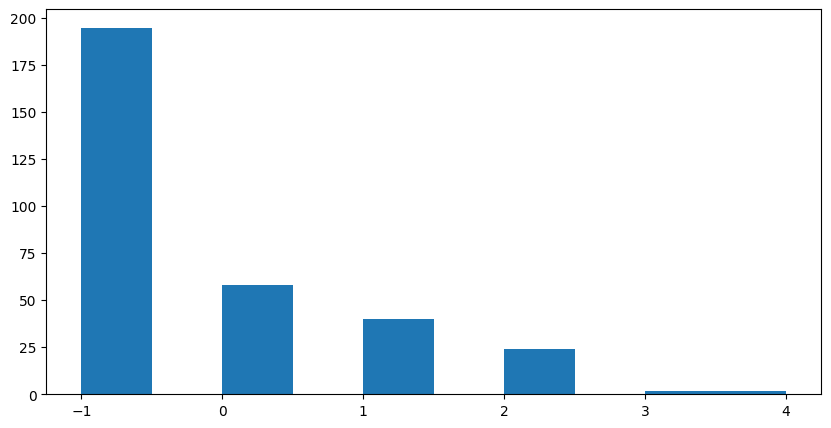

In [24]:
hist(school)

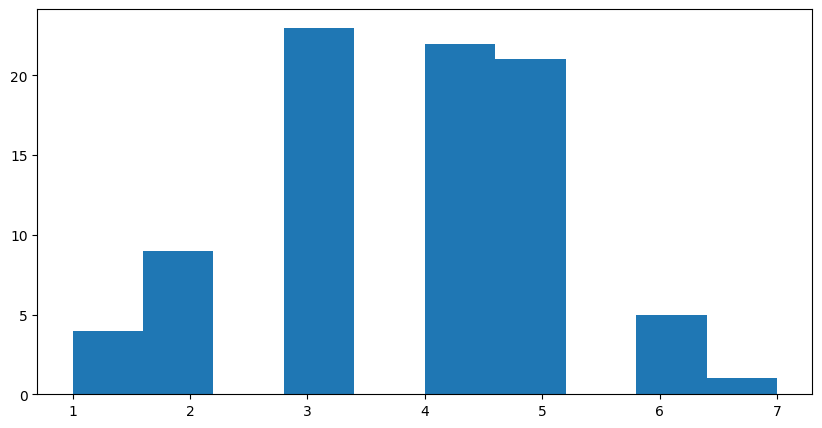

In [25]:
family_sizes = [0] * Family.count
for person in Person.people:
    family_sizes[person.family] = family_sizes[person.family] + 1

hist(family_sizes)

In [26]:
print(mean(family_sizes))

3.776470588235294


In [27]:
data = {
    'id': id,
    'age': age,
    'bmi': bmi,
    'apartment': apartment,
    'home': home,
    'family': family,
    'office': office,
    'school': school
}
meta = pd.DataFrame(data)

# Contact Network

In [28]:
class ContactNetwork:

    def __init__(self, society):
        self.society = society
        self.timestamp = []
        self.p1 = []
        self.p2 = []
        self.time = 0

    def pick_contacts(self, pool, scale):
        n = int(len(pool) * scale)
        pool = list(pool)
        if len(pool) == 0:
            return
        for _ in range(n):
            self.p1.append(random.choice(list(pool)))
            self.p2.append(random.choice(list(pool)))
            self.timestamp.append(self.time)

    def build_contacts(self):
        for day in range(30):
            self.time = self.time + 1
            for apartment in self.society.apartments:
                self.pick_contacts(apartment.people, CONTROL_PARAMS['APARTMENT_CONTACTS_SCALE'])

            self.time = self.time + 1
            for office in self.society.offices:
                self.pick_contacts(office.employees, CONTROL_PARAMS['OFFICE_CONTACTS_SCALE'])
            for school in [self.society.pre, self.society.primary, self.society.secondary, self.society.college, self.society.uni]:
                self.pick_contacts(school.students, CONTROL_PARAMS['SCHOOL_CONTACTS_SCALE'])

            #self.time = self.time + 1
            #NUM_SHOPS = Person.count // SHOP_CAPACITY + 1
            #shops = [[]] * NUM_SHOPS
            #for person in Person.people:
                #if random.random() <= 0.4:
                    #shops[random.randint(1, NUM_SHOPS) - 1].append(person.id)
            #for shop in shops:if age == None else random.randint(age[0], age[1])
                #self.pick_contacts(shop, SHOP_CONTACTS_SCALE)
            #for shop in shops:if bmi == None else random.randint(bmi[0], bmi[1])
                #self.pick_contacts(shop, SHOP_CONTACTS_SCALE)

            self.time = self.time + 1
            for apartment in self.society.apartments:
                for family in apartment.families:
                    self.pick_contacts(family.members, CONTROL_PARAMS['FAMILY_CONTACTS_SCALE'])
            for home in self.society.homes:
                self.pick_contacts(home.family.members, CONTROL_PARAMS['FAMILY_CONTACTS_SCALE'])
                


        data = {
            'timestamp': self.timestamp,
            'p1': self.p1,
            'p2': self.p2,
        }
        cn = pd.DataFrame(data)

        return cn

In [29]:
builder = ContactNetwork(society)
cn = builder.build_contacts()

In [44]:
# convert the dictionary to a json file and add a timestamp to give it an unique file name
time_script_run = dt.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
with open('control_params_{}.json'.format(time_script_run), 'w') as outfile:
    json.dump(CONTROL_PARAMS, outfile)

# add a timestamp to the filename of the csv files
cn.to_csv('contact_network_{}.csv'.format(dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")), header = True, index = False)
meta.to_csv('metadata_{}.csv'.format(dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")), header = True, index = False)

In [31]:
meta

,id,age,bmi,apartment,home,family,office,school
0,0,45,20,0,-1,0,2,-1
1,1,32,21,0,-1,0,3,-1
2,2,31,20,0,-1,1,2,-1
3,3,3,17,0,-1,1,-1,0
4,4,1,24,0,-1,1,-1,0
...,...,...,...,...,...,...,...,...
316,316,35,24,-1,24,84,3,-1
317,317,1,18,-1,24,84,-1,0
318,318,5,27,-1,24,84,-1,1
319,319,70,25,-1,24,84,-1,-1


In [32]:
cn

,timestamp,p1,p2
0,1,17,27
1,1,6,29
2,1,13,33
3,1,51,21
4,1,45,65
...,...,...,...
37195,90,317,319
37196,90,320,320
37197,90,320,320
37198,90,320,319


In [33]:
cn_array1 = cn['p1'].to_numpy()
cn_array2 = cn['p2'].to_numpy()

In [34]:
cn_array1

array([ 17,   6,  13, ..., 320, 320, 316], dtype=int64)

In [35]:
cn_array2

array([ 27,  29,  33, ..., 320, 319, 320], dtype=int64)

In [36]:
meta_array = meta.to_numpy()

In [37]:
#g = dgl.graph((cn_array1, cn_array2), num_nodes=Person.count)

NameError: name 'dgl' is not defined

In [ ]:
#g

Graph(num_nodes=308, num_edges=35550,
      ndata_schemes={}
      edata_schemes={})

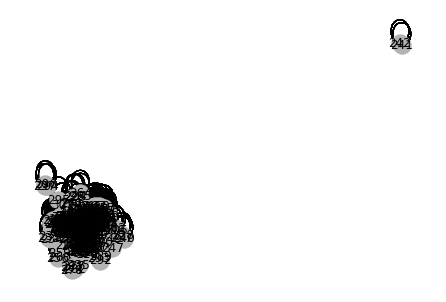

In [ ]:
# A rudimentary visualisation of the entire contact network
"""
nx_g = g.to_networkx().to_undirected()
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]]) """

In [ ]:
#import gnnlens

In [ ]:
#print(gnnlens.__version__)

0.1.0


In [ ]:
"""
# Betweenness centrality is going to be the measure based on which we are going to vaccinate the population
def betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None):

    betweenness = dict.fromkeys(G, 0.0)
    if k is None:
        nodes = G
    else:
        random.seed(seed)
        nodes = random.sample(G.nodes(), k)
    for s in nodes:

        # single source shortest path
        if weight is None: # use BFS
            S, P, sigma = _single_source_shortest_path_basic(G, s)

        # accumulation
        if endpoints:
            betweenness = _accumulate_endpoints(betweenness, S, P, sigma, s)
        else:
            betweenness = _accumulate_basic(betweenness, S, P, sigma, s)

    # rescaling
    betweenness = _rescale(betweenness, len(G), normalized=normalized,
            directed=G.is_directed(), k=k)
    return betweenness
"""

In [ ]:
#G=nx.gnm_random_graph(Person.count, len(cn_array1), seed=None, directed=False)
#b=nx.betweenness_centrality(G)

In [ ]:
# Betweenness centrality of each node
#b

{0: 0.0007375077649534991,
 1: 0.0008558659759107985,
 2: 0.0007654196290826182,
 3: 0.0008390619160325283,
 4: 0.0007671901593974974,
 5: 0.0008631788031049373,
 6: 0.0007623977631823313,
 7: 0.0007540664331532978,
 8: 0.0008322956572558891,
 9: 0.0008208606394805473,
 10: 0.0007638820802945873,
 11: 0.0008240807625795093,
 12: 0.0007527022019424084,
 13: 0.000749879743907772,
 14: 0.0008123097394385233,
 15: 0.0008277659972317452,
 16: 0.00082137070866297,
 17: 0.00081103141630656,
 18: 0.0007966985417568919,
 19: 0.0008504633483841628,
 20: 0.000849381999549594,
 21: 0.0007363177315138268,
 22: 0.0009158515880510789,
 23: 0.0008092730028906874,
 24: 0.0008200851420943634,
 25: 0.0008435015893164692,
 26: 0.0008197070867181085,
 27: 0.0008312381447412731,
 28: 0.0007438339003039739,
 29: 0.0008719729801202139,
 30: 0.0007896687221569305,
 31: 0.0008935247037011926,
 32: 0.0008214488386294566,
 33: 0.0008474477742230454,
 34: 0.0007647162191572348,
 35: 0.0007673398289173043,
 36: 0.0

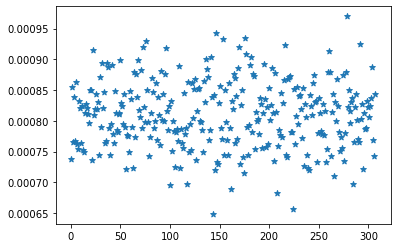

In [ ]:
# In order to check if the values in b are random/not
#plt.scatter(b.keys(), b.values(), marker='*')
#plt.show()

In [ ]:
# Select the 20% of the nodes with the highest centrality and we ahve to vaccinate those nodes
#nodes_to_be_vaccinated = dict(sorted(b.items(), key = itemgetter(1), reverse = True)[:int(0.2*(Person.count))])

In [ ]:
#nodes_to_be_vaccinated 

{278: 0.0009701227628476856,
 146: 0.0009429146624042948,
 176: 0.0009346931381603558,
 153: 0.0009336142463088142,
 76: 0.0009297629786264246,
 292: 0.0009249398437190235,
 216: 0.0009234997704842924,
 170: 0.0009197218151486713,
 73: 0.0009197111643448107,
 96: 0.0009186634382540022,
 22: 0.0009158515880510789,
 260: 0.0009129805901370645,
 177: 0.0009094501793376769,
 141: 0.0009040954642490431,
 182: 0.0009032016216711688,
 136: 0.0009012930972295248,
 68: 0.0008994754058672521,
 50: 0.0008994717162625331,
 36: 0.0008940618449734203,
 31: 0.0008935247037011926,
 195: 0.0008926238128740995,
 181: 0.0008916177177603191,
 41: 0.000890641163344663,
 109: 0.000889436815296082,
 304: 0.000888218416277183,
 37: 0.0008880829298710291,
 169: 0.0008865305787714356,
 203: 0.0008857264381748418,
 137: 0.0008837047000573194,
 71: 0.0008828412021274346,
 91: 0.0008817905334812994,
 261: 0.0008802177222360861,
 64: 0.0008799286107806542,
 277: 0.0008798340623605048,
 259: 0.0008790848981575838,
 

In [ ]:
"""
def eigenvector_centrality(G, max_iter=100, tol=1.0e-6, nstart=None, weight ='weight'):
    from math import sqrt
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise nx.NetworkXException("Not defined for multigraphs.")
  
    if len(G) == 0:
        raise nx.NetworkXException("Empty graph.")
  
    if nstart is None:
  
        # choose starting vector with entries of 1/len(G)
        x = dict([(n,1.0/len(G)) for n in G])
    else:
        x = nstart
  
    # normalize starting vector
    s = 1.0/sum(x.values())
    for k in x:
        x[k] *= s
    nnodes = G.number_of_nodes()
  
    # make up to max_iter iterations
    for i in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A
        for n in x:
            for nbr in G[n]:
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)
  
        # normalize vector
        try:
            s = 1.0/sqrt(sum(v**2 for v in x.values()))
  
        # this should never be zero?
        except ZeroDivisionError:
            s = 1.0
        for n in x:
            x[n] *= s
  
        # check convergence
        err = sum([abs(x[n]-xlast[n]) for n in x])
        if err < nnodes*tol:
            return x """

In [ ]:
#G = nx.gnm_random_graph(Person.count, len(cn_array1), seed=None, directed=False)
#e = nx.eigenvector_centrality(G)

In [ ]:
#e

{0: 0.05256410761032755,
 1: 0.0577050633501333,
 2: 0.056714758949457114,
 3: 0.05550792537678347,
 4: 0.05678188067244317,
 5: 0.05557501601528258,
 6: 0.056603687672037384,
 7: 0.05841317395588861,
 8: 0.05635559878590228,
 9: 0.05653217030393318,
 10: 0.05912278286535332,
 11: 0.05796081599666938,
 12: 0.05680506622186511,
 13: 0.0544443451534673,
 14: 0.05874370630904861,
 15: 0.05622551969838841,
 16: 0.05843243258360348,
 17: 0.05815495565326518,
 18: 0.05647830189013021,
 19: 0.05830841137530572,
 20: 0.05486194825910965,
 21: 0.05998048607127089,
 22: 0.060630896324076165,
 23: 0.059557329138462886,
 24: 0.05903355453116483,
 25: 0.0569305673032473,
 26: 0.056510291933818284,
 27: 0.052105581620416966,
 28: 0.05648957980178098,
 29: 0.05929740454901093,
 30: 0.05640091688301388,
 31: 0.055029981858876045,
 32: 0.05823373148485984,
 33: 0.05522120802270523,
 34: 0.05814645219909049,
 35: 0.060019537402199966,
 36: 0.05393895018240246,
 37: 0.06014300777452598,
 38: 0.0555383144

In [ ]:
# Select the 20% of the nodes with the highest centrality and we ahve to vaccinate those nodes
#nodes_to_be_vaccinated = dict(sorted(e.items(), key = itemgetter(1), reverse = True)[:int(0.2*(Person.count))])

In [ ]:
#nodes_to_be_vaccinated 

{266: 0.06239933640745171,
 252: 0.06167763740095798,
 192: 0.061641916845506996,
 307: 0.061177361192134544,
 173: 0.060926567621603735,
 120: 0.06089258608797197,
 199: 0.06077002245130942,
 281: 0.06075398095010134,
 165: 0.06063102606545884,
 22: 0.060630896324076165,
 222: 0.06061293184847814,
 98: 0.06061292864571494,
 175: 0.060380107056644386,
 282: 0.06035708610567204,
 59: 0.06015527706910301,
 37: 0.06014300777452598,
 35: 0.060019537402199966,
 72: 0.06000239090839207,
 95: 0.05999937809066868,
 21: 0.05998048607127089,
 121: 0.05994322005486096,
 302: 0.05990450635018938,
 260: 0.059877575748852586,
 301: 0.059698723352556944,
 64: 0.05969537575765986,
 212: 0.05959331243838898,
 23: 0.059557329138462886,
 244: 0.059544336490976374,
 198: 0.059528584181600806,
 84: 0.05942612324812129,
 39: 0.059367544728941485,
 29: 0.05929740454901093,
 202: 0.05923366478676751,
 137: 0.059225591446005865,
 131: 0.05920812007804669,
 183: 0.05914165826182068,
 10: 0.05912278286535332,
 1

In [ ]:
#G = nx.gnm_random_graph(Person.count, len(cn_array1), seed=None, directed=False)
#e = nx.eigenvector_centrality(G)

In [ ]:
#e

{0: 0.05814980134476592,
 1: 0.05646668612128406,
 2: 0.0569246174840051,
 3: 0.0589212064243244,
 4: 0.05515877973193582,
 5: 0.057573734702010555,
 6: 0.05595061423530261,
 7: 0.058516431091875924,
 8: 0.05699738348485293,
 9: 0.05548616216514704,
 10: 0.054463809151716745,
 11: 0.05747275944314369,
 12: 0.05896416438642429,
 13: 0.05371764536182243,
 14: 0.056928653854157005,
 15: 0.05744938407887062,
 16: 0.05669950054272606,
 17: 0.05582309077067443,
 18: 0.057000639191294535,
 19: 0.056548200888755236,
 20: 0.05753356730613159,
 21: 0.058395206640965494,
 22: 0.060697878518502675,
 23: 0.05645300383432861,
 24: 0.056174865191641284,
 25: 0.05500652987220649,
 26: 0.06258328733280823,
 27: 0.055443153269691896,
 28: 0.059273317630312704,
 29: 0.057418563307382535,
 30: 0.057631066874408755,
 31: 0.058951752308965835,
 32: 0.054486317646789795,
 33: 0.05719775133503345,
 34: 0.05946968829286841,
 35: 0.05507401458323107,
 36: 0.05593320225908855,
 37: 0.05891503529420072,
 38: 0.05

In [ ]:
# Select the 20% of the nodes with the highest centrality and we ahve to vaccinate those nodes
#nodes_to_be_vaccinated = dict(sorted(e.items(), key = itemgetter(1), reverse = True)[:int(0.2*(Person.count))])

In [ ]:
#nodes_to_be_vaccinated 

{26: 0.06258328733280823,
 270: 0.061863725806414596,
 240: 0.06073965850921105,
 22: 0.060697878518502675,
 271: 0.060650281828584396,
 232: 0.060633525914072256,
 145: 0.0606273142652069,
 183: 0.060521294029992984,
 48: 0.060433531457262234,
 213: 0.060408181069608755,
 103: 0.06036143922295941,
 266: 0.06028693453185755,
 49: 0.06022630324569455,
 81: 0.06021733559533503,
 259: 0.05990655786823754,
 191: 0.0598251154528551,
 77: 0.05970199057077737,
 125: 0.05965041174529844,
 249: 0.05951207492499005,
 45: 0.059497065482216824,
 34: 0.05946968829286841,
 136: 0.059461111504919825,
 261: 0.059459131175981596,
 74: 0.05943879964954044,
 62: 0.059425822824925534,
 230: 0.05927554221141358,
 28: 0.059273317630312704,
 233: 0.05927078346008677,
 242: 0.059247336706585475,
 53: 0.05924097766146328,
 107: 0.05923860760982651,
 220: 0.059236126396927935,
 184: 0.05923420686575243,
 40: 0.05922274458139804,
 295: 0.05921761330131016,
 171: 0.05921672255709984,
 202: 0.05920317662298086,
 2